In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

import colorednoise as cn

from hr.esm import EsmModel, BlockEsmModel
from hr.preprocess import NoiseWhitening, FilterBank
from hr.process import Esprit, Ester, AdaptiveEsprit, BlockEsprit
from hr.decomp import EsmSubspaceDecomposer
from hr.util import _PINK_FILTRE_COEFFS
from expr.analysis import load_analysis
from util.util import to_db, snr, load_data_json

%matplotlib widget
# %matplotlib inline

### Simple noiseless 'harmonic' signal

In [77]:
sr = 44100
n_s = 100000
n_fft = 1024

# number of sinusoids
r = 32
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas = rng.uniform(0.001, 0.01, r) 
# Normalised frequencies
nus = rng.uniform(0.01, 0.5, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_esm = EsmModel(gammas, nus, amps, phis)

x_sine = x_esm.synth(n_s)

n_est = 512
p_max = 128
r_est = Ester.estimate_esm_order(x_sine, n_est, p_max)
x_esm_est = Esprit.estimate_esm(x_sine, n_est, r_est)

print(x_esm.nus * sr)
print(x_esm_est.nus * sr)
print(x_esm.gammas * sr)
print(x_esm_est.gammas * sr)
print(x_esm.phis / np.pi)
print(x_esm_est.phis / np.pi)

[  693.62760167   951.25529456  1271.78419375  1399.55218982
  2459.87339665  4078.84703531  4508.04800203  4594.34777106
  4974.12113272  5779.74031204  5975.03099314  6963.88609882
  8249.38240718  9437.65410421  9785.91515379 10067.31422649
 12243.21042356 14128.05223773 15105.77373383 16147.80176993
 17230.76974197 17435.31354598 17538.63654289 17646.22654107
 18395.11212986 18505.016215   18835.02976615 19494.18599898
 20166.95790721 20410.03038448 21089.56910526 21873.77801928]
[  693.62760167   951.25529456  1271.78419375  1399.55218982
  2459.87339665  4078.84703531  4508.04800203  4594.34777106
  4974.12113272  5779.74031204  5975.03099314  6963.88609882
  8249.38240718  9437.65410421  9785.91515379 10067.31422649
 12243.21042356 14128.05223773 15105.77373383 16147.80176993
 17230.76974197 17435.31354598 17538.63654289 17646.22654107
 18395.11212986 18505.016215   18835.02976615 19494.18599898
 20166.95790721 20410.03038448 21089.56910526 21873.77801928]
[413.83142912 107.6135

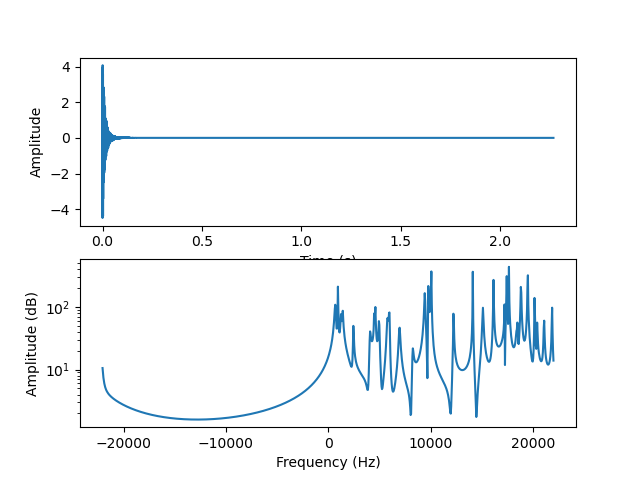

In [78]:
ts_plot = np.arange(n_s) / sr # times in seconds
fs_plot = np.fft.fftfreq(n_fft) * sr

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_plot), np.fft.fftshift(np.abs(x_sine_ft)))
plt.show()

In [79]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

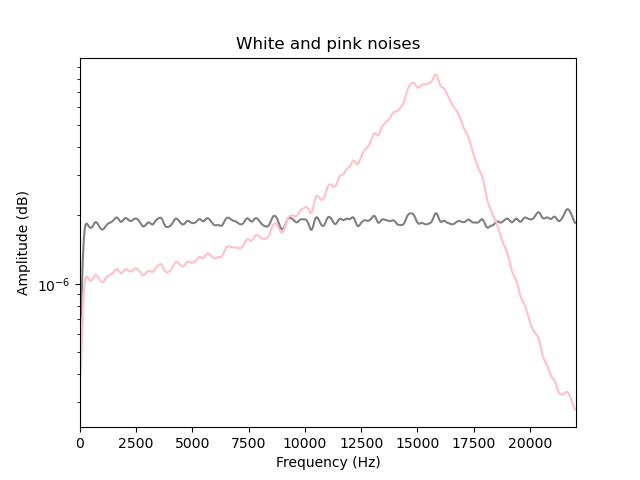

In [80]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft, return_onesided=False)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("White and pink noises")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(white_noise_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(pink_noise_psd), c='pink')
plt.xlim(np.array([0, 0.5])*sr)
plt.show()

### Whitening the noise

In [87]:
noise_ratio = 0.004
noise = noise_ratio*pink_noise

x = x_sine + noise
x_snr =snr(np.real(x_sine), noise)
print(f'SNR={x_snr} dB')

SNR=33.395445928711226 dB


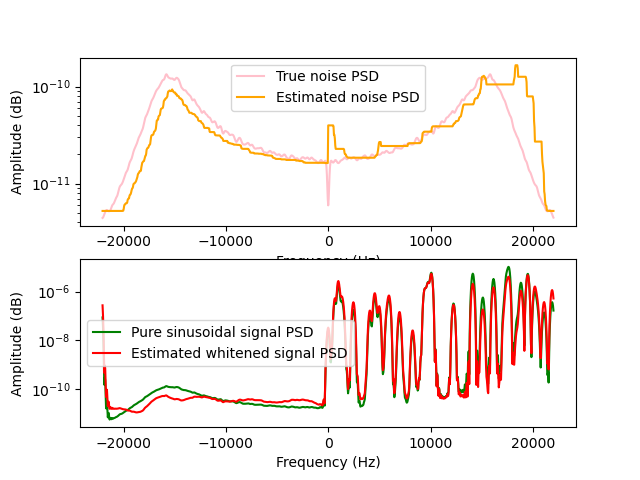

In [ ]:
smoothing_factor = 10
quantile_ratio = 0.05
ar_order = 10

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft, return_onesided=False)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft, return_onesided=False)

noise_psd_est = NoiseWhitening.estimate_noise_psd(x, fs=sr, n_fft=n_fft, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
noise_filtre_coeffs_est = NoiseWhitening.estimate_noise_ar_coeffs(noise_psd_est, ar_order=ar_order)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white, _ = NoiseWhitening.whiten(x, fs=sr, n_fft=n_fft, ar_order=ar_order, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft, return_onesided=False)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("PSD estimation of the noise and whitened signal")
plt.subplot(2, 1, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_noise_psd), np.fft.fftshift(noise_psd), c='pink', label="True noise PSD")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(noise_psd_est), c='orange', label="Estimated noise PSD")
plt.legend()
# plt.xlim(np.array([0, 0.5]) * sr)
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
# plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_psd), c='green', label="Pure sinusoidal signal PSD")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='r', label="Estimated whitened signal PSD")
plt.legend()
plt.show()

In [89]:
ipd.Audio(np.real(x), rate=sr)


### ESM model ordre estimation

#### Does seem to work correctly with the whitened signal!

The whitening process seems to hurt the estimation
of the ESM model ordre with ESTER.
We should use ESTER with the signal whose noise
has not been whitened.

#### Choice of $p_{max}$

According to the article, $p_{max}$ should be 
much lower than $n$.
So according to our expectation on $r$, we should choose
$n$ large enough.

Still unclear, but if $p_{max} > r$
the _a posteriori error bound_ from $E$ 
gives some indication somehow?

In the article:

For each eigenvalue ̂$\hat{z}$ of $\Phi(p)$, 
there is an eigenvalue $z_k$ of $\Phi(r)$ for which:

$$
|\hat{z} − z_k| \leq \kappa_2 ||E(p)||_2
$$ 


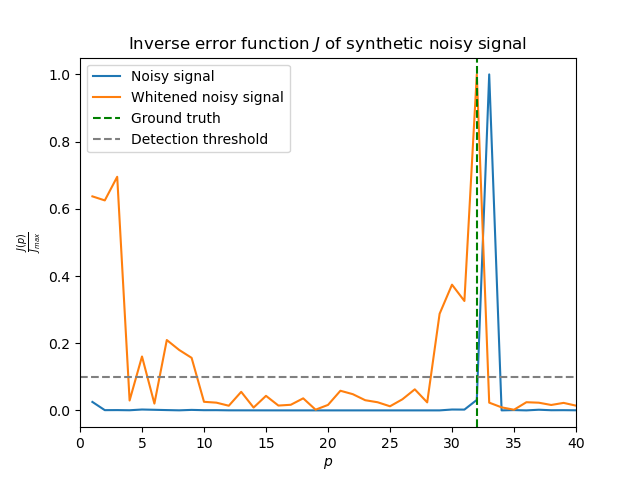

In [96]:
thresh_ratio = 0.1
ps = np.arange(1,p_max+1)
j_sine = Ester.inverse_error_func(x_sine, n=n, p_max=p_max)
j_noise = Ester.inverse_error_func(x, n=n, p_max=p_max)
j_white = Ester.inverse_error_func(x_white, n=n, p_max=p_max)

plt.figure()
plt.title(f"Inverse error function $J$ of synthetic noisy signal")
plt.xlabel('$p$')
plt.ylabel('$\\frac{J(p)}{J_{max}}$')
# plt.plot(ps, j_sine/np.max(j_sine), label="Pure sinusoidal signal")
plt.plot(ps, j_noise/np.max(j_noise), label="Noisy signal")
plt.plot(ps, j_white/np.max(j_white), label="Whitened noisy signal")
plt.axvline(r, ymin=0, ymax=1, c='g', linestyle='--', label="Ground truth")
plt.axhline(thresh_ratio, c='grey', linestyle="--", label="Detection threshold")
plt.xlim(0, 40)
plt.legend()
plt.show()
plt.savefig("aaa.svg")

# r_est_sine = Ester.estimate_esm_order(x_sine, n, p_max)
# r_est_noise = Ester.estimate_esm_order(x, n, p_max)
# r_est_white = Ester.estimate_esm_order(x_white, n, p_max)
# print('Ordre of the ESM model')
# print(f'Truth={r}')
# print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')

### Test of the model with whitened signal


We use the ESM model ordre estimated on the 
whitened signal, and apply ESPRIT on
the whitened signal.

In [91]:
# x_esm_est = Esprit.estimate_esm(x_white, n, r_est_white)
decomp = EsmSubspaceDecomposer(
    fs=sr,
    n_esprit=n,
    p_max_ester=p_max,
    n_fft_noise=n_fft,
    smoothing_factor_noise=smoothing_factor,
    quantile_ratio_noise=quantile_ratio,
    clip_damp_esm=False,
    discard_freq_esm=False,
    correct_alphas_noise=True
)
x_esm_est, x_noise, x_white = decomp.perform(x)


# print(x_esm.nus * sr)
# print(x_esm_est.nus * sr)
# print(x_esm.phis / np.pi)
# print(x_esm_est.phis / np.pi)
# print(x_esm.amps)
# print(x_esm_est.amps)

plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model order")
# plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey', label="Pure sinusoids")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange', label="Whitened noisy signal")
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
    pass
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [ ]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est), rate=sr)

In [ ]:
# Noise part
ipd.Audio(np.real(x_noise), rate=sr)

### Filter bank


#### Problem

__What transformation to apply to the estimated frequency in the band $\nu_{i}^b$ to apply to find the estimated frequency $\nu_i^b$?__

$$
\nu_i^b = \frac{\nu_{i,\text{band}}^b}{d} + \nu_c^b
$$

With $\nu_c^b = \frac{b}{N_{bands}}$ the centre frequency for band $b$, $N_{bands}$ the number of bands, and $d$ the decimation factor.

[0.02370348 0.06644552 0.08388054 0.08417023 0.10485837 0.10681606
 0.15001347 0.15960831]
[0.02370189]


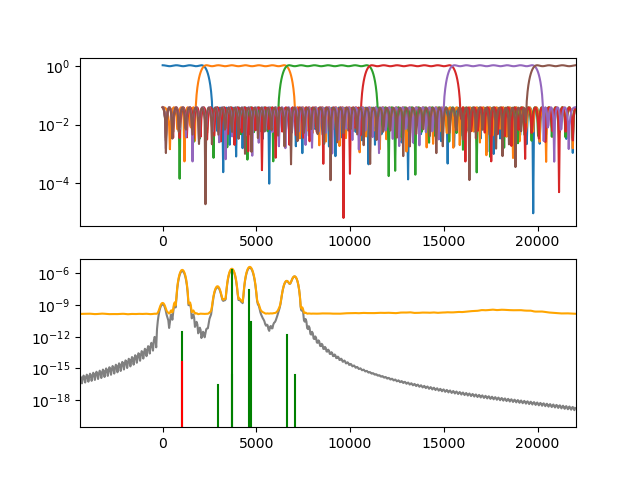

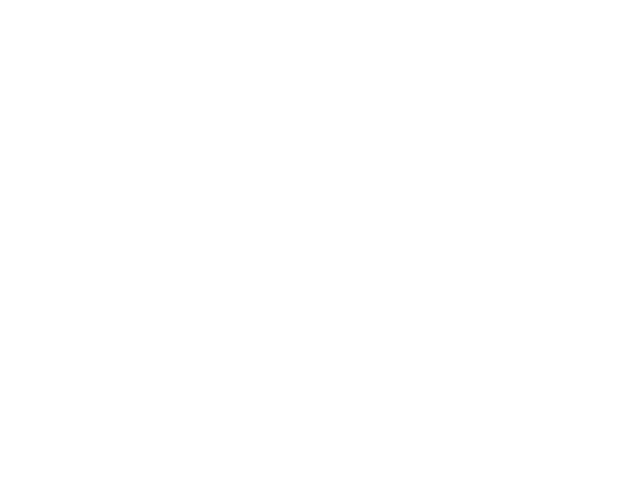

In [14]:
# number of bands
nb_bands = 6
decimation_factor = nb_bands // 2
order_filter = 126
w_trans = 0.02

clip_damp = True
discard_freq = True

decomp = EsmSubspaceDecomposer(
    fs=sr,
    n_esprit=n,
    p_max_ester=p_max,
    n_fft_noise=n_fft,
    smoothing_factor_noise=smoothing_factor,
    quantile_ratio_noise=quantile_ratio,
    nb_bands_bank=nb_bands,
    decimation_factor_bank=decimation_factor,
    order_filter_bank=order_filter,
    w_trans_bank=w_trans,
    clip_damp_esm=False,
    discard_freq_esm=False,
    correct_alphas_noise=True
)
x_esm_est, x_noise, x_white = decomp.perform(x)

print(x_esm.nus)
print(x_esm_est.nus)
#print(x_esm_est.nus * sr)
#print(x_esm_est.nus * sr)
plt.close("all")
plt.clf()
plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
if decomp.bank is not None:
    plt.subplot(2, 1, 1)
    plt.xlim(np.array([-0.1, 0.5])*sr)
    for b in range(decomp.bank.nb_bands):
        omegas, amps = sig.freqz(decomp.bank.filter_coeffs[b], [1])
        nus = omegas / (2 * np.pi)
        plt.semilogy(nus * sr, np.abs(amps))
        # plt.axvline(decomp.bank.nus_centre[b] * sr, 0, 1, c='pink')
    plt.subplot(2, 1, 2)
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')

plt.show()

In [15]:
ipd.Audio(np.real(x)/np.max(np.abs(x)), rate=sr)

In [16]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Adaptive ESPRIT

#### Using a custom adaptive ESM

In [17]:
sr = 4410
n_s = 8000
n_fft = 1024

log_progress = False

nb_blocks = 10
l_block = n_s // nb_blocks
# number of sinusoids
r = 8
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas_list = np.repeat(rng.normal(0.002, 0.0001, (nb_blocks, r)), l_block, axis=0)
# Normalised frequencies
nus_list = np.repeat(rng.normal(0.1, 0.05, (nb_blocks, r)), l_block, axis=0)
amps_list = np.repeat(rng.uniform(0.1, 1, (nb_blocks, r)), l_block, axis=0)
phis_list = np.repeat(rng.uniform(0, 2 * np.pi, (nb_blocks, r)), l_block, axis=0)

x_esm = BlockEsmModel.from_param_lists(
    gammas_list, nus_list, amps_list, phis_list
)

# one sample per value
x_sine = x_esm.synth(1)

n_est = 32
l = 120
x_esm_est = BlockEsprit.estimate_esm(
    x_sine, n_est, r, l, step=50
)

# print(x_esm.nus[0] * sr)
# print(x_esm_est.nus[0] * sr)
# print(x_esm.gammas * sr)
# print(x_esm_est.gammas * sr)

# x_sine_est = x_esm_est.synth(n_s_block)


[138.47121009 138.47121009 138.47121009 ... 264.99213043 264.99213043
 264.99213043]
[-386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.15363886
 -386.15363886 -386.15363886 -386.15363886 -386.15363886 -386.1

### Recorded signal

In [2]:
# Loading config from config files
conf_dir = pathlib.Path('./config/expr/')
data_dir = pathlib.Path('../data/expr/2022_01_27')
#
log_path = conf_dir / 'log_config.json'
conf_path = conf_dir / 'analysis_config.json'
data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_5cmFromBridge_1.mat'

log = load_data_json(log_path)
conf = load_data_json(conf_path)
expr_data = load_analysis(data_path, conf)

In [3]:
sr = expr_data["sr"]
acc = expr_data["temporal"]["acc"]["win"]
mic = expr_data["temporal"]["mic"]["win"]
mic_white = expr_data["hr"]["mic"]["win"]["white"]
acc_white = expr_data["hr"]["acc"]["win"]["white"]
times_acc = expr_data["times"]["acc"]["win"]
times_mic = expr_data["times"]["mic"]["win"]

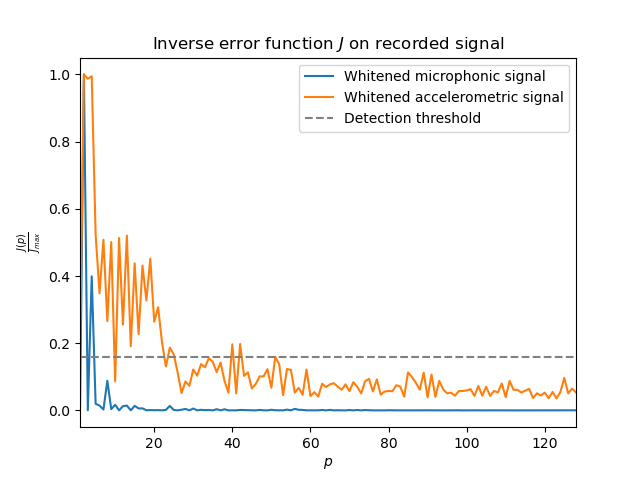

In [4]:
n = conf.hr.esprit.n
p_max = conf.hr.ester.p_max # for now
thresh_ratio = conf.hr.ester.thresh_ratio
ps = np.arange(1,p_max+1)
j_mic = Ester.inverse_error_func(acc, n=n, p_max=p_max)
j_mic_white = Ester.inverse_error_func(mic_white, n=n, p_max=p_max)
j_acc = Ester.inverse_error_func(mic, n=n, p_max=p_max)
j_acc_white= Ester.inverse_error_func(acc_white, n=n, p_max=p_max)

plt.figure()
plt.title(f"Inverse error function $J$ on recorded signal")
plt.xlabel('$p$')
plt.ylabel('$\\frac{J(p)}{J_{max}}$')
plt.plot(ps, j_mic_white/np.max(j_mic_white), label="Whitened microphonic signal")
plt.plot(ps, j_acc_white/np.max(j_acc_white), label="Whitened accelerometric signal")
plt.axhline(thresh_ratio, c='grey', linestyle="--", label="Detection threshold")
plt.xlim(1, p_max)
plt.legend()
plt.show()
plt.savefig("aaa.svg")

In [5]:
# x_esm_est = Esprit.estimate_esm(x_white, n, r_est_white)
decomp = EsmSubspaceDecomposer(
        fs=sr,
        n_esprit=conf.hr.esprit.n,
        p_max_ester=conf.hr.ester.p_max,
        n_fft_noise=conf.hr.whitening.n_fft,
        thresh_ratio_ester=conf.hr.ester.thresh_ratio,
        nb_bands_bank=conf.hr.filter_bank.nb_bands,
        order_filter_bank=conf.hr.filter_bank.order_filter,
        w_trans_bank=conf.hr.filter_bank.w_trans,
        # TODO: set according to data -> excit, acc, etc.
        smoothing_factor_noise=conf.hr.whitening.smoothing_factor,
        quantile_ratio_noise=conf.hr.whitening.quantile_ratio,
        clip_damp_esm=conf.hr.esprit.clip_damp,
        discard_freq_esm=conf.hr.esprit.discard_freq,
        correct_alphas_noise=conf.hr.whitening.correct_alphas,
)

In [6]:
x  = acc
n_cap = len(times_acc)
x_esm, x_noise, x_white = decomp.perform(x)
x_sine = x_esm.synth(n_cap)

In [7]:
ipd.Audio(x, rate=sr)

In [8]:
ipd.Audio(np.real(x_sine), rate=sr)

In [9]:

ipd.Audio(np.real(x_noise), rate=sr)